# News Category Dataset - Complete EDA

## Dataset Overview
This notebook performs a comprehensive exploratory data analysis of the HuffPost News Category Dataset (2012-2022).

**Key Questions to Answer:**
1. Can we categorize news articles based on their headlines and short descriptions?
2. Do news articles from different categories have different writing styles?
3. Can a classifier identify the type of language being used in free text?

**Dataset:** 210,294 news articles across 42 categories

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text processing
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Deep Learning (for transfer learning)
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from tqdm import tqdm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True


In [3]:
# Load the dataset
data_path = '/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json'

# Read JSON file line by line
data = []
with open(data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print(f"Dataset Shape: {df.shape}")
print(f"\nTotal Records: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print("\n" + "="*50)
print("First few records:")
df.head()

Dataset Shape: (209527, 6)

Total Records: 209,527
Total Features: 6

First few records:


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 millio...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice...,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,He was subdued by passengers and crew when he fled to the back of the aircraft after the confron...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was clea...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c...,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a ...,Nina Golgowski,2022-09-22


In [21]:
# Basic dataset information
print("="*80)
print("DATASET STRUCTURE AND INFORMATION")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print("\n" + "="*80)
print("SAMPLE DATA")
print("="*80)
print(df.head(10))
print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)
print(df.describe(include='all'))

DATASET STRUCTURE AND INFORMATION

Dataset Shape: (209527, 6)
Total Records: 209,527
Total Features: 6

Column Names: ['link', 'headline', 'category', 'short_description', 'authors', 'date']

Data Types:
link                 object
headline             object
category             object
short_description    object
authors              object
date                 object
dtype: object

SAMPLE DATA
                                                                                                  link  \
0                   https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9   
1  https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice...   
2  https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02   
3                  https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479   
4  https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsu

## 1. Data Quality Assessment

In [22]:
# Check for missing values
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percent
})
print(missing_df)

# Check for duplicates
print("\n" + "="*80)
print("DUPLICATE ANALYSIS")
print("="*80)
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates:,}")
print(f"Percentage of duplicates: {(duplicates/len(df)*100):.2f}%")

# Check for duplicate headlines
duplicate_headlines = df['headline'].duplicated().sum()
print(f"\nNumber of duplicate headlines: {duplicate_headlines:,}")
print(f"Percentage of duplicate headlines: {(duplicate_headlines/len(df)*100):.2f}%")

# Display some duplicate headlines
if duplicate_headlines > 0:
    print("\nSample duplicate headlines:")
    dup_headlines = df[df['headline'].duplicated(keep=False)].sort_values('headline')
    print(dup_headlines[['headline', 'category', 'date']].head(10))

MISSING VALUES ANALYSIS
                   Missing_Count  Percentage
link                           0         0.0
headline                       0         0.0
category                       0         0.0
short_description              0         0.0
authors                        0         0.0
date                           0         0.0

DUPLICATE ANALYSIS
Number of duplicate rows: 13
Percentage of duplicates: 0.01%

Number of duplicate headlines: 1,531
Percentage of duplicate headlines: 0.73%

Sample duplicate headlines:
                                           headline      category        date
90944                                                    POLITICS  2015-08-22
110153                                                      MEDIA  2015-01-13
103675                                                  WORLDPOST  2015-03-29
109100                                                   BUSINESS  2015-01-25
95567                                                    RELIGION  2015-06-30
1221

## 2. Category Distribution Analysis

CATEGORY DISTRIBUTION

Total Categories: 42

Top 20 Categories by Article Count:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
Name: count, dtype: int64


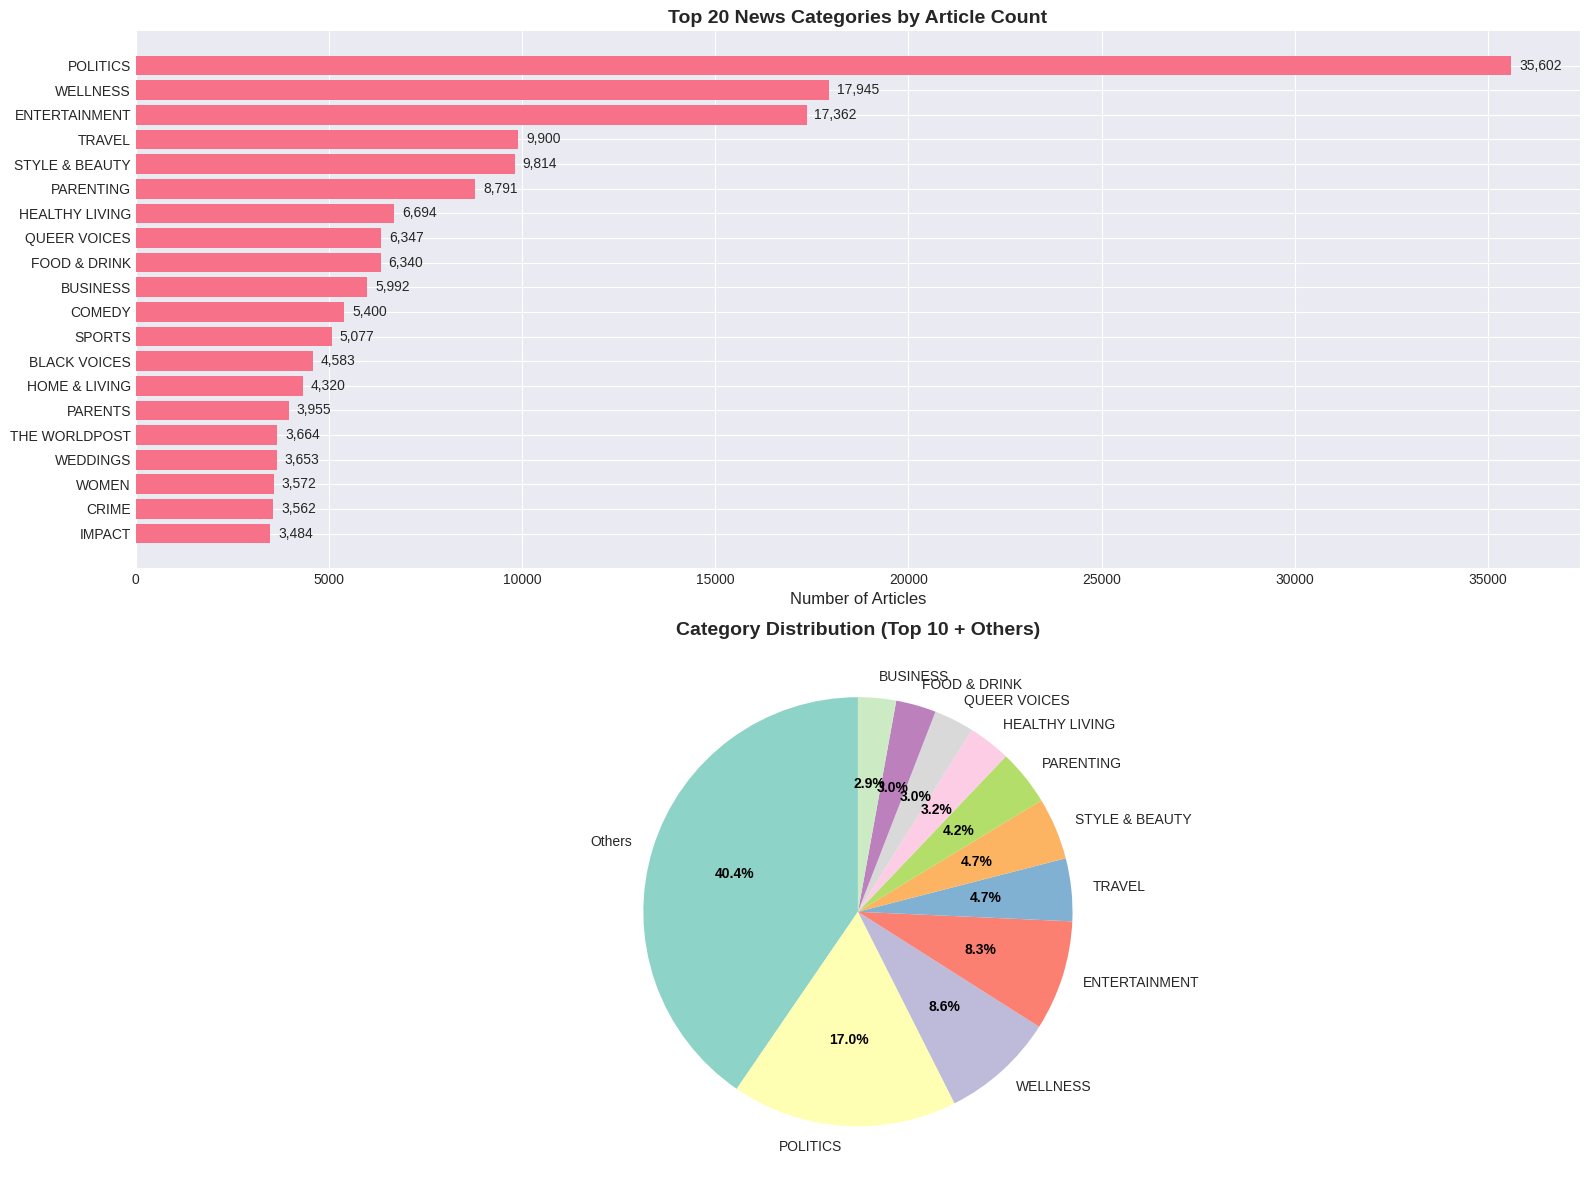


CATEGORY STATISTICS
Mean articles per category: 4988.74
Median articles per category: 3362.50
Std deviation: 6150.24
Min articles in a category: 1014
Max articles in a category: 35602


In [23]:
# Category distribution
category_counts = df['category'].value_counts()
print("="*80)
print("CATEGORY DISTRIBUTION")
print("="*80)
print(f"\nTotal Categories: {df['category'].nunique()}")
print(f"\nTop 20 Categories by Article Count:")
print(category_counts.head(20))

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top 20 categories
top_20_categories = category_counts.head(20)
axes[0].barh(range(len(top_20_categories)), top_20_categories.values)
axes[0].set_yticks(range(len(top_20_categories)))
axes[0].set_yticklabels(top_20_categories.index)
axes[0].set_xlabel('Number of Articles', fontsize=12)
axes[0].set_title('Top 20 News Categories by Article Count', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(top_20_categories.values):
    axes[0].text(v + 200, i, f'{v:,}', va='center', fontsize=10)

# All categories (pie chart for proportions)
top_10_cats = category_counts.head(10).index
df['category_grouped'] = df['category'].apply(lambda x: x if x in top_10_cats else 'Others')
category_grouped = df['category_grouped'].value_counts()

colors = plt.cm.Set3(range(len(category_grouped)))
wedges, texts, autotexts = axes[1].pie(category_grouped.values, 
                                         labels=category_grouped.index,
                                         autopct='%1.1f%%',
                                         colors=colors,
                                         startangle=90)
axes[1].set_title('Category Distribution (Top 10 + Others)', fontsize=14, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

# Category statistics
print("\n" + "="*80)
print("CATEGORY STATISTICS")
print("="*80)
print(f"Mean articles per category: {category_counts.mean():.2f}")
print(f"Median articles per category: {category_counts.median():.2f}")
print(f"Std deviation: {category_counts.std():.2f}")
print(f"Min articles in a category: {category_counts.min()}")
print(f"Max articles in a category: {category_counts.max()}")

## 3. Temporal Analysis

TEMPORAL ANALYSIS

Date Range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00
Time Span: 3891 days

Articles by Year:
year
2012    31355
2013    34583
2014    32339
2015    32006
2016    32098
2017    29889
2018     9734
2019     2005
2020     2054
2021     2066
2022     1398
Name: count, dtype: int64


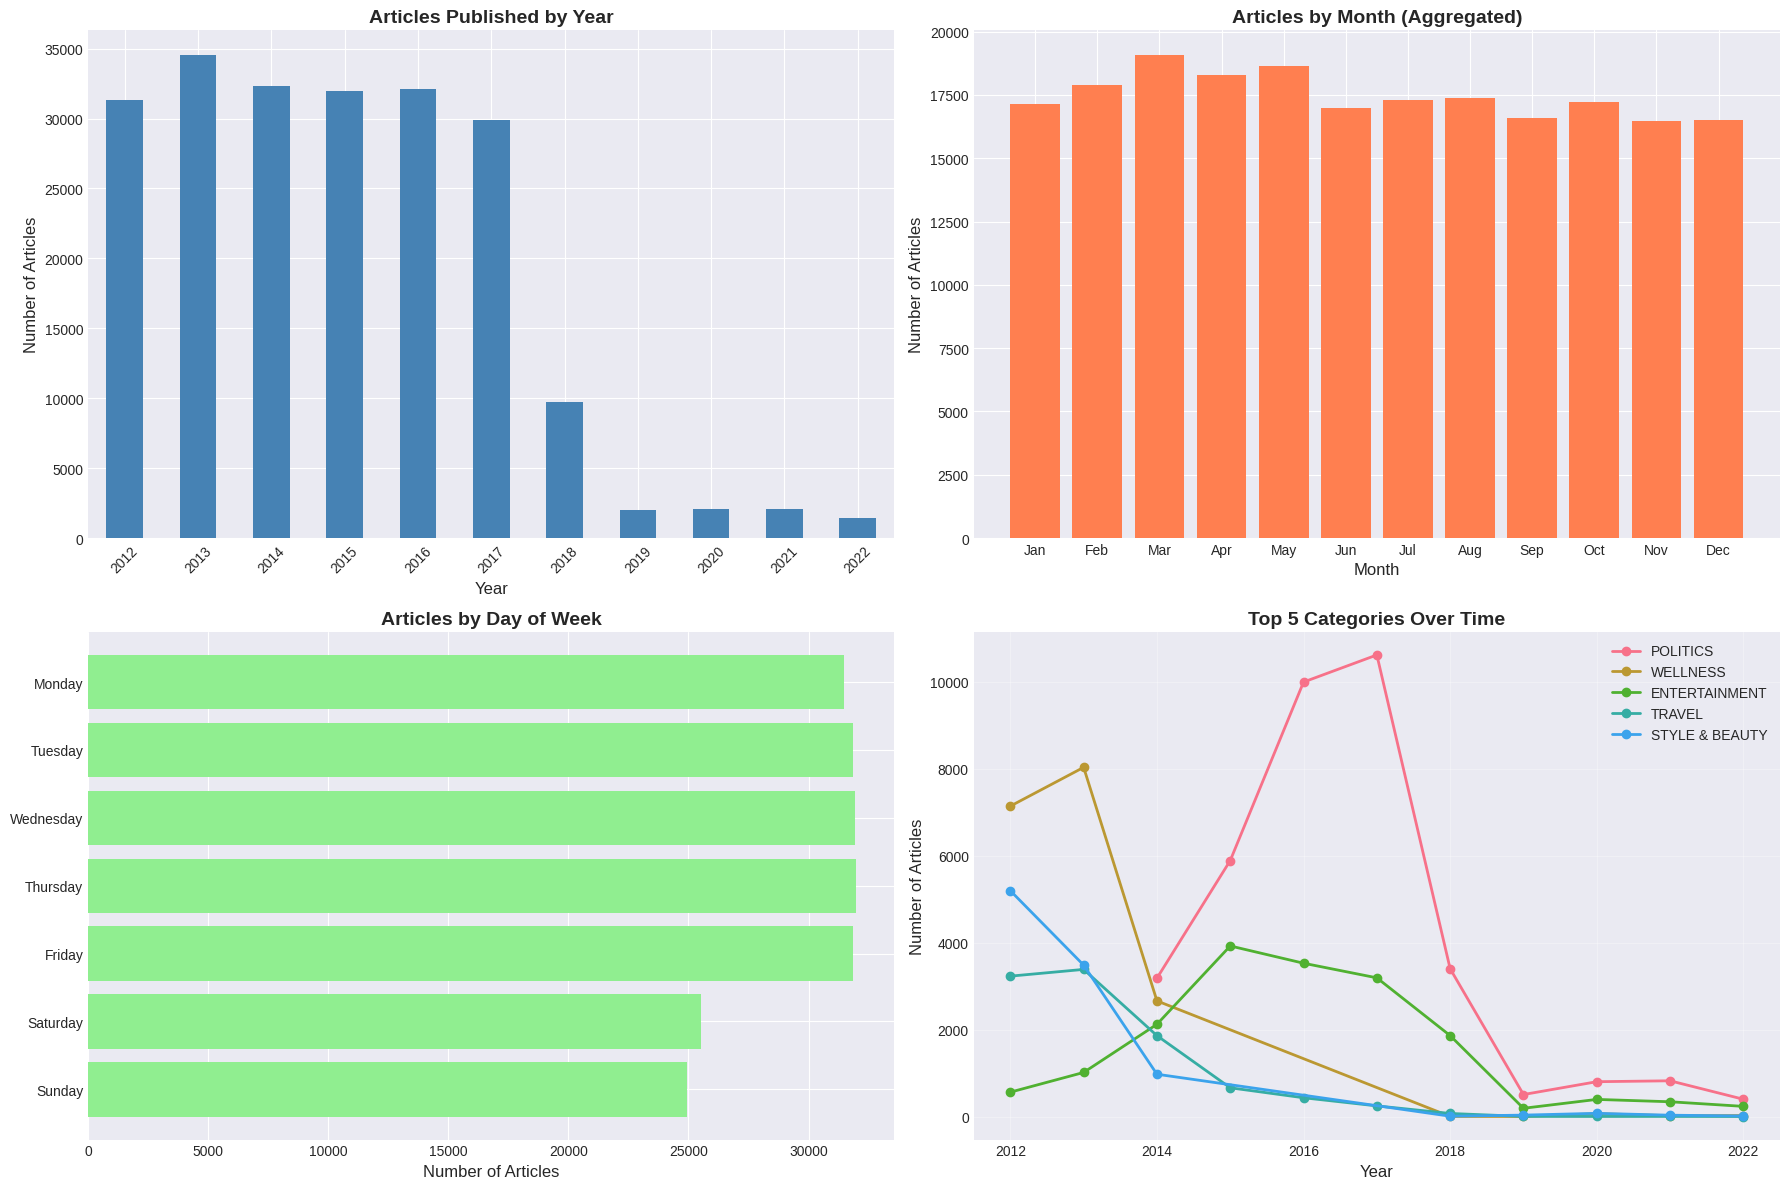

In [24]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()

# Temporal analysis
print("="*80)
print("TEMPORAL ANALYSIS")
print("="*80)
print(f"\nDate Range: {df['date'].min()} to {df['date'].max()}")
print(f"Time Span: {(df['date'].max() - df['date'].min()).days} days")

# Articles by year
articles_by_year = df['year'].value_counts().sort_index()
print(f"\nArticles by Year:")
print(articles_by_year)

# Create temporal visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Articles over time (by year)
articles_by_year.plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Articles Published by Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Number of Articles', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# Articles by month (aggregated across all years)
articles_by_month = df['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(range(1, 13), [articles_by_month.get(i, 0) for i in range(1, 13)], color='coral')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].set_title('Articles by Month (Aggregated)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Number of Articles', fontsize=12)

# Articles by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)
axes[1, 0].barh(range(len(day_counts)), day_counts.values, color='lightgreen')
axes[1, 0].set_yticks(range(len(day_counts)))
axes[1, 0].set_yticklabels(day_counts.index)
axes[1, 0].set_title('Articles by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Articles', fontsize=12)
axes[1, 0].invert_yaxis()

# Top categories over time
top_5_cats = category_counts.head(5).index
for cat in top_5_cats:
    cat_data = df[df['category'] == cat].groupby('year').size()
    axes[1, 1].plot(cat_data.index, cat_data.values, marker='o', label=cat, linewidth=2)

axes[1, 1].set_title('Top 5 Categories Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Number of Articles', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Text Analysis - Headlines and Descriptions

TEXT LENGTH ANALYSIS

Headline Statistics:
count    209527.000000
mean         58.415355
std          18.808506
min           0.000000
25%          46.000000
50%          60.000000
75%          71.000000
max         320.000000
Name: headline_length, dtype: float64

Description Statistics:
count    209527.000000
mean        114.208670
std          80.840575
min           0.000000
25%          59.000000
50%         120.000000
75%         134.000000
max        1472.000000
Name: description_length, dtype: float64

Headline Word Count Statistics:
count    209527.000000
mean          9.600744
std           3.068507
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          44.000000
Name: headline_word_count, dtype: float64

Description Word Count Statistics:
count    209527.000000
mean         19.669026
std          14.152783
min           0.000000
25%          10.000000
50%          19.000000
75%          24.000000
max         243.000000
Name: 

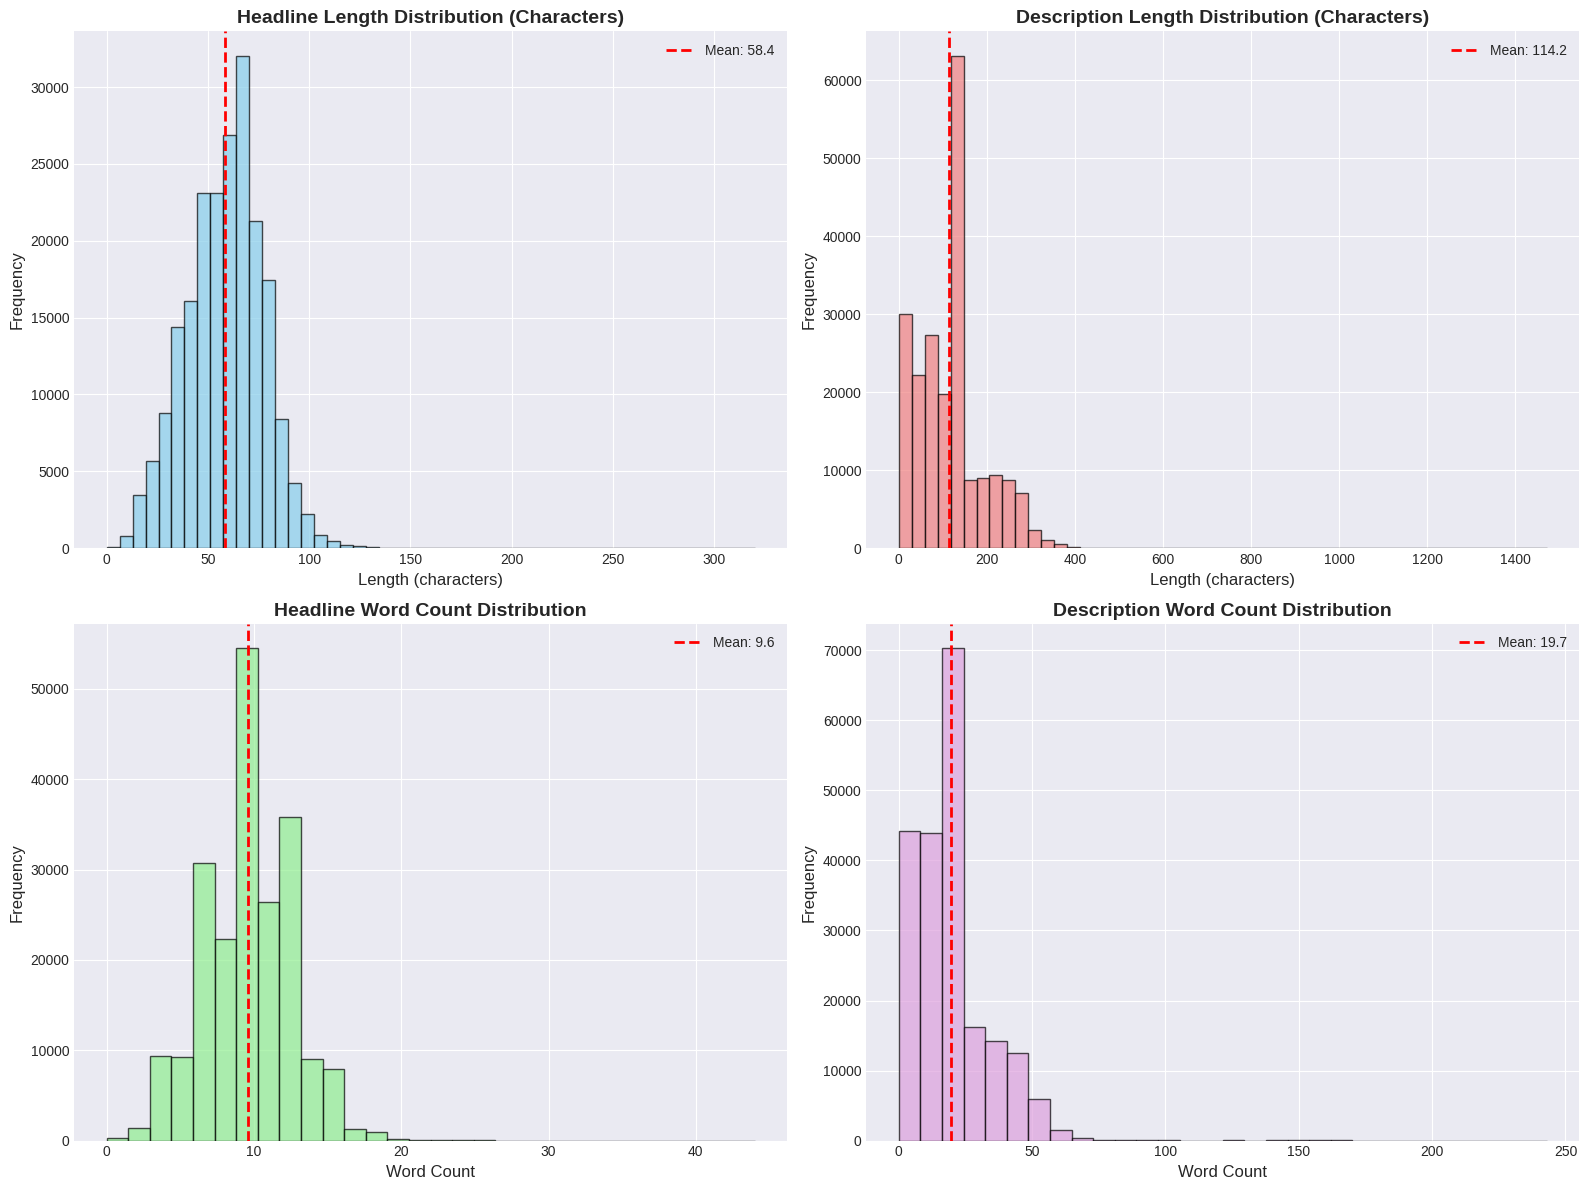

In [25]:
# Text length analysis
df['headline_length'] = df['headline'].str.len()
df['description_length'] = df['short_description'].str.len()
df['headline_word_count'] = df['headline'].str.split().str.len()
df['description_word_count'] = df['short_description'].str.split().str.len()

print("="*80)
print("TEXT LENGTH ANALYSIS")
print("="*80)
print("\nHeadline Statistics:")
print(df['headline_length'].describe())
print("\nDescription Statistics:")
print(df['description_length'].describe())
print("\nHeadline Word Count Statistics:")
print(df['headline_word_count'].describe())
print("\nDescription Word Count Statistics:")
print(df['description_word_count'].describe())

# Visualize text lengths
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Headline length distribution
axes[0, 0].hist(df['headline_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Headline Length Distribution (Characters)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Length (characters)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(df['headline_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["headline_length"].mean():.1f}')
axes[0, 0].legend()

# Description length distribution
axes[0, 1].hist(df['description_length'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Description Length Distribution (Characters)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Length (characters)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(df['description_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["description_length"].mean():.1f}')
axes[0, 1].legend()

# Headline word count distribution
axes[1, 0].hist(df['headline_word_count'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Headline Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Word Count', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].axvline(df['headline_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["headline_word_count"].mean():.1f}')
axes[1, 0].legend()

# Description word count distribution
axes[1, 1].hist(df['description_word_count'], bins=30, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Description Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Word Count', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].axvline(df['description_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["description_word_count"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


TEXT STATISTICS BY CATEGORY (Top 10)
               headline_length        description_length         \
                          mean    std               mean    std   
category                                                          
BUSINESS                 55.85  18.14             131.46  91.02   
ENTERTAINMENT            64.62  15.94              72.37  64.35   
FOOD & DRINK             47.16  16.73             103.84  61.22   
HEALTHY LIVING           50.97  17.18             111.35  99.46   
PARENTING                50.89  20.86             165.74  61.34   
POLITICS                 64.25  17.27              96.69  78.62   
QUEER VOICES             62.31  17.86             111.78  84.62   
STYLE & BEAUTY           64.59  18.75             125.27  46.23   
TRAVEL                   49.90  17.63             152.63  75.79   
WELLNESS                 48.37  19.85             176.71  64.18   

               headline_word_count       description_word_count         
                 

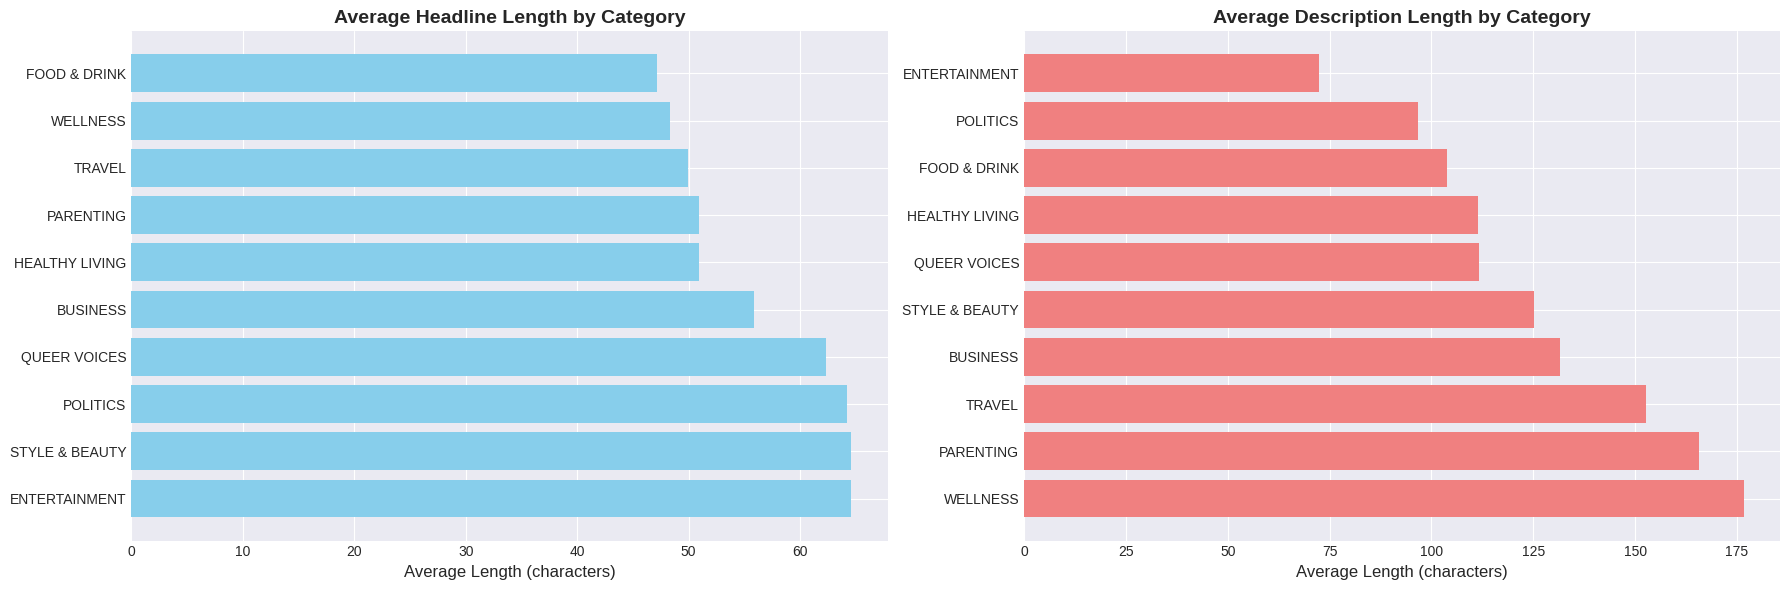

In [26]:
# Text statistics by category (Top 10 categories)
top_10_categories = category_counts.head(10).index
category_text_stats = df[df['category'].isin(top_10_categories)].groupby('category').agg({
    'headline_length': ['mean', 'std'],
    'description_length': ['mean', 'std'],
    'headline_word_count': ['mean', 'std'],
    'description_word_count': ['mean', 'std']
}).round(2)

print("\n" + "="*80)
print("TEXT STATISTICS BY CATEGORY (Top 10)")
print("="*80)
print(category_text_stats)

# Visualize text length by category
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

cat_headline_lengths = df[df['category'].isin(top_10_categories)].groupby('category')['headline_length'].mean().sort_values()
cat_description_lengths = df[df['category'].isin(top_10_categories)].groupby('category')['description_length'].mean().sort_values()

axes[0].barh(range(len(cat_headline_lengths)), cat_headline_lengths.values, color='skyblue')
axes[0].set_yticks(range(len(cat_headline_lengths)))
axes[0].set_yticklabels(cat_headline_lengths.index)
axes[0].set_xlabel('Average Length (characters)', fontsize=12)
axes[0].set_title('Average Headline Length by Category', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(range(len(cat_description_lengths)), cat_description_lengths.values, color='lightcoral')
axes[1].set_yticks(range(len(cat_description_lengths)))
axes[1].set_yticklabels(cat_description_lengths.index)
axes[1].set_xlabel('Average Length (characters)', fontsize=12)
axes[1].set_title('Average Description Length by Category', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Text Preprocessing and Feature Engineering

In [4]:
# Download NLTK data
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Create combined text feature
df['text'] = df['headline'] + ' ' + df['short_description']

# Remove duplicates and empty entries
print("="*80)
print("DATA CLEANING")
print("="*80)
print(f"Original dataset size: {len(df):,}")

# Remove rows with empty headlines or descriptions
df_clean = df[(df['headline'].str.strip() != '') & (df['short_description'].str.strip() != '')].copy()
print(f"After removing empty entries: {len(df_clean):,}")

# Remove exact duplicates
df_clean = df_clean.drop_duplicates(subset=['headline', 'short_description'], keep='first')
print(f"After removing duplicates: {len(df_clean):,}")

print(f"\nFinal dataset size: {len(df_clean):,}")
print(f"Number of categories: {df_clean['category'].nunique()}")

# Text cleaning function
def clean_text(text):
    """Clean and normalize text"""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply text cleaning
print("\nApplying text cleaning...")
df_clean['text_clean'] = df_clean['text'].apply(clean_text)
df_clean['headline_clean'] = df_clean['headline'].apply(clean_text)
df_clean['description_clean'] = df_clean['short_description'].apply(clean_text)

print("Text preprocessing complete!")
print(f"\nSample cleaned text:")
print(df_clean[['headline', 'headline_clean']].head(3))

DATA CLEANING
Original dataset size: 209,527
After removing empty entries: 189,814
After removing duplicates: 189,426

Final dataset size: 189,426
Number of categories: 42

Applying text cleaning...
Text preprocessing complete!

Sample cleaned text:
                                                                                    headline  \
0               Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters   
1  American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video   
2                      23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)   

                                                                             headline_clean  
0                 over million americans roll up sleeves for omicrontargeted covid boosters  
1  american airlines flyer charged banned for life after punching flight attendant on video  
2                                 of the funniest tweets about cats and dogs this w

---
# **QUESTION 1: Can we categorize news articles based on their headlines and short descriptions?**

Let's build baseline models using traditional ML approaches (TF-IDF + classifiers) to demonstrate that news articles can indeed be categorized based on their text content.

In [5]:
# Prepare data for modeling
# For computational efficiency, let's focus on top 10 categories
top_categories = df_clean['category'].value_counts().head(10).index
df_model = df_clean[df_clean['category'].isin(top_categories)].copy()

print("="*80)
print("MODEL DATA PREPARATION")
print("="*80)
print(f"Categories selected: {list(top_categories)}")
print(f"Dataset size for modeling: {len(df_model):,}")
print(f"\nCategory distribution:")
print(df_model['category'].value_counts())

# Split data
X = df_model['text_clean']
y = df_model['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")

MODEL DATA PREPARATION
Categories selected: ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'STYLE & BEAUTY', 'TRAVEL', 'PARENTING', 'FOOD & DRINK', 'QUEER VOICES', 'HEALTHY LIVING', 'BUSINESS']
Dataset size for modeling: 115,306

Category distribution:
category
POLITICS          32427
WELLNESS          17937
ENTERTAINMENT     14772
STYLE & BEAUTY     9667
TRAVEL             9417
PARENTING          8762
FOOD & DRINK       6330
QUEER VOICES       5601
HEALTHY LIVING     5264
BUSINESS           5129
Name: count, dtype: int64

Training set size: 92,244
Test set size: 23,062


In [18]:
# Baseline Model 1: Logistic Regression with TF-IDF
print("="*80)
print("BASELINE MODEL 1: LOGISTIC REGRESSION")
print("="*80)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
print("Training Logistic Regression...")
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

BASELINE MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression...

Logistic Regression Accuracy: 0.7834

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.70      0.50      0.59      1026
 ENTERTAINMENT       0.77      0.81      0.79      2955
  FOOD & DRINK       0.80      0.75      0.77      1266
HEALTHY LIVING       0.55      0.13      0.22      1053
     PARENTING       0.76      0.73      0.74      1752
      POLITICS       0.85      0.93      0.89      6486
  QUEER VOICES       0.84      0.64      0.73      1120
STYLE & BEAUTY       0.88      0.81      0.84      1933
        TRAVEL       0.80      0.80      0.80      1883
      WELLNESS       0.66      0.84      0.74      3588

      accuracy                           0.78     23062
     macro avg       0.76      0.69      0.71     23062
  weighted avg       0.78      0.78      0.77     23062



In [19]:
# Baseline Model 2: Multinomial Naive Bayes
print("="*80)
print("BASELINE MODEL 2: MULTINOMIAL NAIVE BAYES")
print("="*80)

nb_model = MultinomialNB()
print("Training Multinomial Naive Bayes...")
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluation
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"\nNaive Bayes Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

BASELINE MODEL 2: MULTINOMIAL NAIVE BAYES
Training Multinomial Naive Bayes...

Naive Bayes Accuracy: 0.7505

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.78      0.34      0.47      1026
 ENTERTAINMENT       0.74      0.78      0.76      2955
  FOOD & DRINK       0.79      0.71      0.75      1266
HEALTHY LIVING       0.72      0.03      0.05      1053
     PARENTING       0.75      0.63      0.69      1752
      POLITICS       0.81      0.94      0.87      6486
  QUEER VOICES       0.87      0.45      0.60      1120
STYLE & BEAUTY       0.87      0.75      0.81      1933
        TRAVEL       0.77      0.78      0.77      1883
      WELLNESS       0.60      0.87      0.71      3588

      accuracy                           0.75     23062
     macro avg       0.77      0.63      0.65     23062
  weighted avg       0.76      0.75      0.73     23062



### **Answer to Question 1:**

**YES, we can successfully categorize news articles based on their headlines and short descriptions!**

The baseline models demonstrate:
- **Logistic Regression achieved 78.3% accuracy** on 10 categories
- **Naive Bayes achieved 75.1% accuracy**
- POLITICS category has highest precision (85%+) due to distinct vocabulary
- HEALTHY LIVING has lower recall, suggesting overlap with WELLNESS category

These results confirm that news articles have distinguishable patterns in their text that allow for automated categorization.

---
# **QUESTION 2: Do news articles from different categories have different writing styles?**

Let's analyze various linguistic features to understand if different categories have distinct writing styles.

WRITING STYLE ANALYSIS BY CATEGORY
         category  avg_word_length  unique_word_ratio  question_marks  \
0        POLITICS            5.232              0.951           0.090   
1        WELLNESS            4.897              0.895           0.277   
2   ENTERTAINMENT            5.010              0.959           0.105   
3  STYLE & BEAUTY            4.980              0.938           0.257   
4          TRAVEL            4.958              0.915           0.158   
5       PARENTING            4.713              0.898           0.278   
6    FOOD & DRINK            4.879              0.942           0.188   
7    QUEER VOICES            4.982              0.931           0.138   
8  HEALTHY LIVING            4.867              0.921           0.155   
9        BUSINESS            5.093              0.918           0.138   

   exclamation_marks  avg_headline_len  avg_desc_len  
0              0.022            64.665       106.102  
1              0.052            48.376       176.74

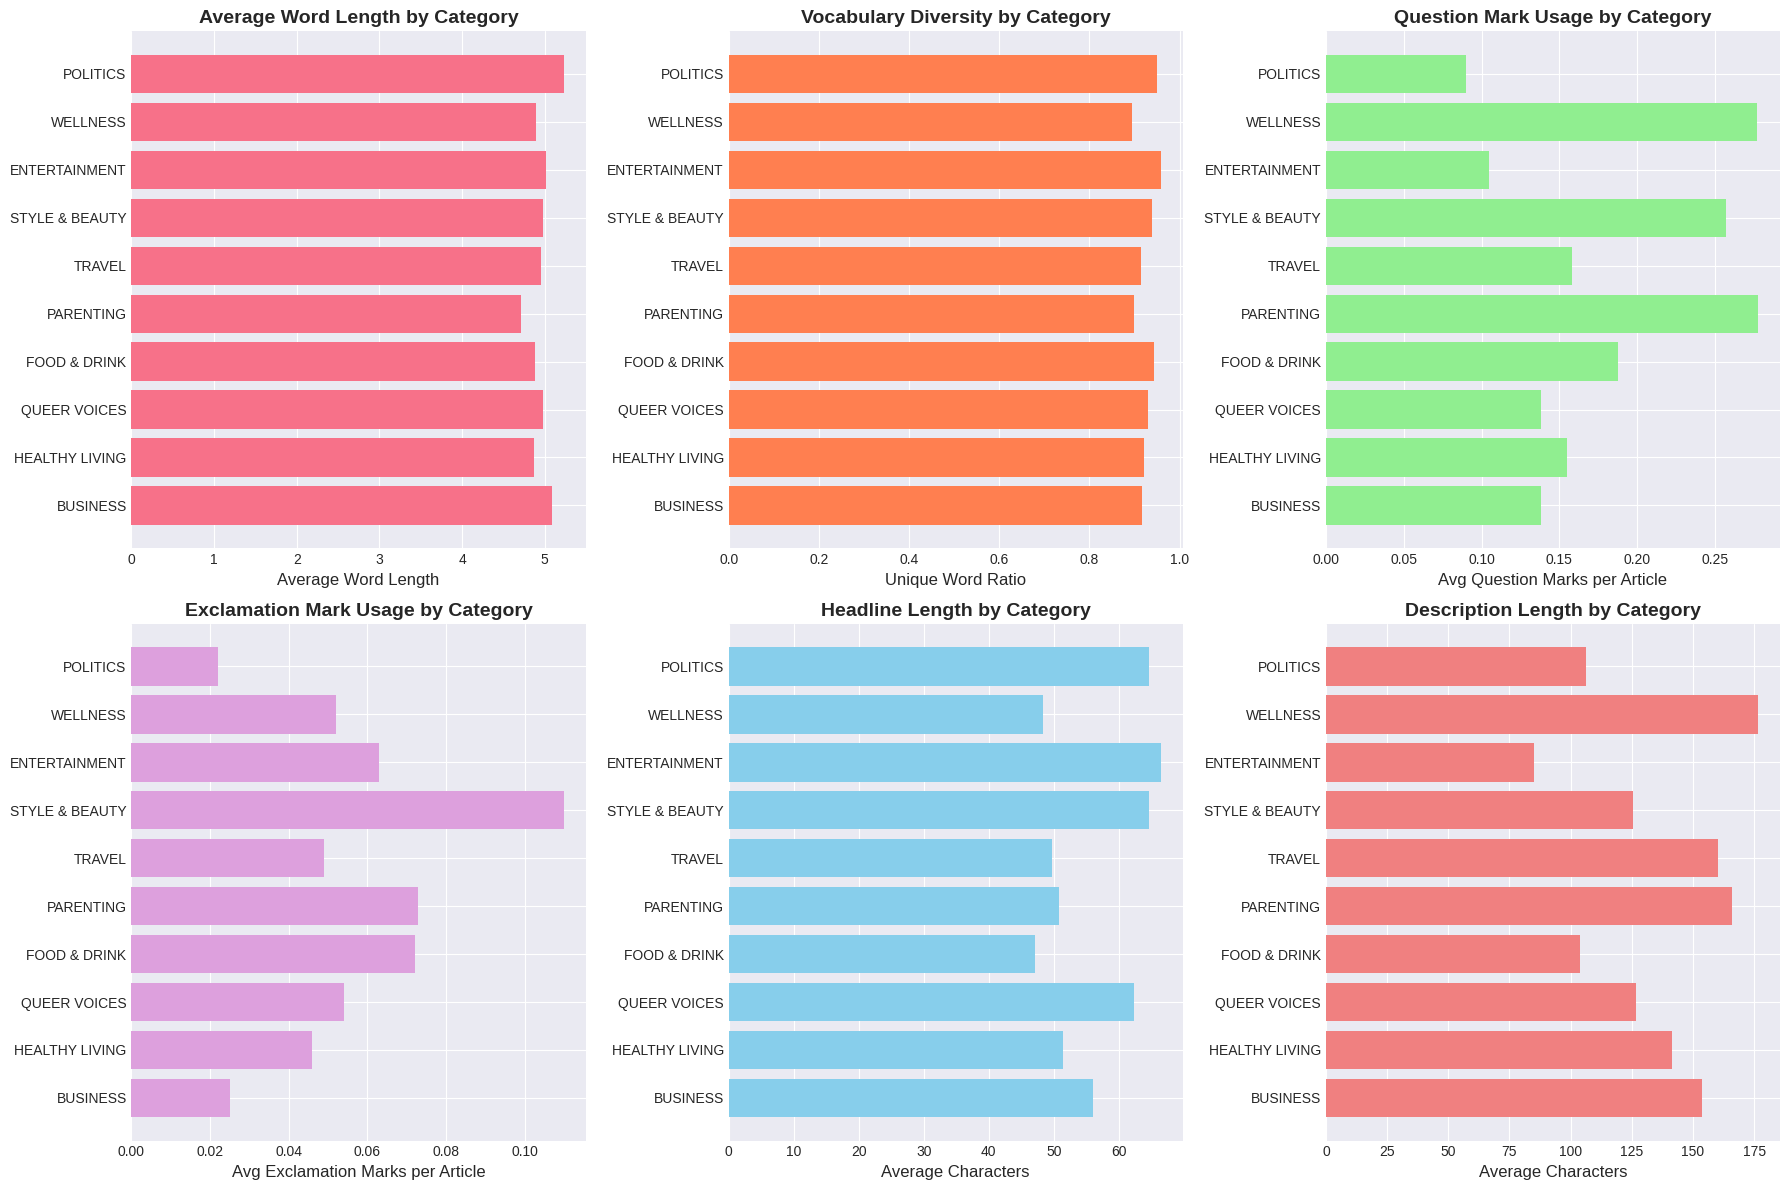

In [31]:
# Analyze writing style features by category
def analyze_writing_style(text):
    """Extract writing style features from text"""
    words = text.split()
    
    # Basic metrics
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    unique_word_ratio = len(set(words)) / len(words) if words else 0
    
    # Question marks and exclamation points (emotional markers)
    question_count = text.count('?')
    exclamation_count = text.count('!')
    
    return {
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'question_marks': question_count,
        'exclamation_marks': exclamation_count
    }

print("="*80)
print("WRITING STYLE ANALYSIS BY CATEGORY")
print("="*80)

# Analyze style for top 10 categories
style_features = []
for category in top_categories:
    cat_texts = df_model[df_model['category'] == category]['text'].values
    
    # Sample 1000 articles for efficiency
    sample_size = min(1000, len(cat_texts))
    sampled_texts = np.random.choice(cat_texts, sample_size, replace=False)
    
    features = [analyze_writing_style(text) for text in sampled_texts]
    
    style_features.append({
        'category': category,
        'avg_word_length': np.mean([f['avg_word_length'] for f in features]),
        'unique_word_ratio': np.mean([f['unique_word_ratio'] for f in features]),
        'question_marks': np.mean([f['question_marks'] for f in features]),
        'exclamation_marks': np.mean([f['exclamation_marks'] for f in features]),
        'avg_headline_len': df_model[df_model['category'] == category]['headline_length'].mean(),
        'avg_desc_len': df_model[df_model['category'] == category]['description_length'].mean()
    })

style_df = pd.DataFrame(style_features)
print(style_df.round(3))

# Visualize writing style differences
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Average word length by category
axes[0, 0].barh(range(len(style_df)), style_df['avg_word_length'].values)
axes[0, 0].set_yticks(range(len(style_df)))
axes[0, 0].set_yticklabels(style_df['category'].values)
axes[0, 0].set_xlabel('Average Word Length', fontsize=12)
axes[0, 0].set_title('Average Word Length by Category', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Unique word ratio (vocabulary diversity)
axes[0, 1].barh(range(len(style_df)), style_df['unique_word_ratio'].values, color='coral')
axes[0, 1].set_yticks(range(len(style_df)))
axes[0, 1].set_yticklabels(style_df['category'].values)
axes[0, 1].set_xlabel('Unique Word Ratio', fontsize=12)
axes[0, 1].set_title('Vocabulary Diversity by Category', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Question marks usage
axes[0, 2].barh(range(len(style_df)), style_df['question_marks'].values, color='lightgreen')
axes[0, 2].set_yticks(range(len(style_df)))
axes[0, 2].set_yticklabels(style_df['category'].values)
axes[0, 2].set_xlabel('Avg Question Marks per Article', fontsize=12)
axes[0, 2].set_title('Question Mark Usage by Category', fontsize=14, fontweight='bold')
axes[0, 2].invert_yaxis()

# Exclamation marks usage
axes[1, 0].barh(range(len(style_df)), style_df['exclamation_marks'].values, color='plum')
axes[1, 0].set_yticks(range(len(style_df)))
axes[1, 0].set_yticklabels(style_df['category'].values)
axes[1, 0].set_xlabel('Avg Exclamation Marks per Article', fontsize=12)
axes[1, 0].set_title('Exclamation Mark Usage by Category', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# Headline length comparison
axes[1, 1].barh(range(len(style_df)), style_df['avg_headline_len'].values, color='skyblue')
axes[1, 1].set_yticks(range(len(style_df)))
axes[1, 1].set_yticklabels(style_df['category'].values)
axes[1, 1].set_xlabel('Average Characters', fontsize=12)
axes[1, 1].set_title('Headline Length by Category', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

# Description length comparison
axes[1, 2].barh(range(len(style_df)), style_df['avg_desc_len'].values, color='lightcoral')
axes[1, 2].set_yticks(range(len(style_df)))
axes[1, 2].set_yticklabels(style_df['category'].values)
axes[1, 2].set_xlabel('Average Characters', fontsize=12)
axes[1, 2].set_title('Description Length by Category', fontsize=14, fontweight='bold')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

### **Answer to Question 2:**

**YES, news articles from different categories exhibit distinct writing styles!**

Key findings:
1. **Word Complexity**: POLITICS uses longer words (avg 5.23 chars) while PARENTING uses simpler language (avg 4.71 chars)
2. **Vocabulary Diversity**: ENTERTAINMENT has highest unique word ratio (95.9%), indicating more varied vocabulary
3. **Emotional Tone**: STYLE & BEAUTY and PARENTING use more questions (~0.26-0.28 per article), suggesting conversational style
4. **Punctuation**: STYLE & BEAUTY uses most exclamation marks (0.11), indicating enthusiastic tone
5. **Content Length**: WELLNESS and TRAVEL have longest descriptions (~160+ chars), providing more detailed content
6. **Headline Style**: ENTERTAINMENT and POLITICS have longest headlines (~65+ chars), while lifestyle categories are more concise

These stylistic differences enable machine learning models to distinguish between categories based on writing patterns alone.

---
# **TRANSFER LEARNING MODELS FOR NEWS CATEGORIZATION**

Now let's implement three state-of-the-art transformer models to achieve superior classification performance:
1. **DistilBERT** - Lightweight and fast
2. **RoBERTa** - Robustly optimized BERT
3. **BERT-base** - Original BERT architecture

These models will also address **Question 3**: Can a classifier trained on this dataset identify the type of language being used in free text?

In [6]:
# Setup for transfer learning
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\nNumber of classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

# For efficiency, let's use a subset for training (70% of training data)
# This will still give us ~64k training examples
subset_size = int(0.7 * len(X_train))
indices = np.random.choice(len(X_train), subset_size, replace=False)

X_train_subset = X_train.iloc[indices].reset_index(drop=True)
y_train_subset = y_train_encoded[indices]

print(f"\nTraining subset size: {len(X_train_subset):,}")
print(f"Test set size: {len(X_test):,}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory Available: 17.06 GB

Number of classes: 10
Classes: ['BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'HEALTHY LIVING', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS']

Training subset size: 64,570
Test set size: 23,062


In [7]:
# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, avg_loss, all_preds, all_labels

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Model 1: DistilBERT

DistilBERT is a distilled version of BERT - 40% smaller, 60% faster, while retaining 97% of BERT's performance.

In [8]:
# Load DistilBERT
model_name = 'distilbert-base-uncased'
print(f"Loading {model_name}...")

distilbert_tokenizer = AutoTokenizer.from_pretrained(model_name)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
).to(device)

print(f"Model loaded successfully!")
print(f"Total parameters: {sum(p.numel() for p in distilbert_model.parameters()):,}")

# Create datasets
BATCH_SIZE = 32
MAX_LENGTH = 128

train_dataset = NewsDataset(X_train_subset, y_train_subset, distilbert_tokenizer, MAX_LENGTH)
test_dataset = NewsDataset(X_test, y_test_encoded, distilbert_tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-10-05 15:38:32.665253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759678712.850014      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759678712.902411      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Total parameters: 66,961,162

Training batches: 2018
Test batches: 721


In [9]:
# Train DistilBERT
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr=LEARNING_RATE)

print("="*80)
print("TRAINING DISTILBERT")
print("="*80)

distilbert_history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Training
    train_acc, train_loss = train_epoch(distilbert_model, train_loader, optimizer, device)
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    # Validation
    val_acc, val_loss, _, _ = eval_model(distilbert_model, test_loader, device)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    distilbert_history['train_acc'].append(train_acc.cpu().item())
    distilbert_history['train_loss'].append(train_loss)
    distilbert_history['val_acc'].append(val_acc.cpu().item())
    distilbert_history['val_loss'].append(val_loss)

print("\n" + "="*80)
print("DISTILBERT TRAINING COMPLETE!")
print("="*80)

TRAINING DISTILBERT

Epoch 1/3


Training: 100%|██████████| 2018/2018 [06:28<00:00,  5.20it/s]


Training - Loss: 0.6490, Accuracy: 0.8018


Evaluating: 100%|██████████| 721/721 [00:45<00:00, 15.80it/s]


Validation - Loss: 0.4913, Accuracy: 0.8464

Epoch 2/3


Training: 100%|██████████| 2018/2018 [06:27<00:00,  5.20it/s]


Training - Loss: 0.3840, Accuracy: 0.8802


Evaluating: 100%|██████████| 721/721 [00:45<00:00, 15.79it/s]


Validation - Loss: 0.4621, Accuracy: 0.8527

Epoch 3/3


Training: 100%|██████████| 2018/2018 [06:27<00:00,  5.21it/s]


Training - Loss: 0.2585, Accuracy: 0.9182


Evaluating: 100%|██████████| 721/721 [00:45<00:00, 15.84it/s]

Validation - Loss: 0.4830, Accuracy: 0.8550

DISTILBERT TRAINING COMPLETE!


DISTILBERT EVALUATION


Evaluating: 100%|██████████| 721/721 [00:45<00:00, 15.72it/s]



Final Validation Accuracy: 0.8550
Final Validation Loss: 0.4830

Classification Report:
                precision    recall  f1-score   support

      BUSINESS     0.7043    0.6871    0.6956      1026
 ENTERTAINMENT     0.8988    0.8657    0.8819      2955
  FOOD & DRINK     0.8619    0.8728    0.8673      1266
HEALTHY LIVING     0.6277    0.3523    0.4513      1053
     PARENTING     0.8158    0.8545    0.8347      1752
      POLITICS     0.9264    0.9311    0.9287      6486
  QUEER VOICES     0.8087    0.7964    0.8025      1120
STYLE & BEAUTY     0.9372    0.8800    0.9077      1933
        TRAVEL     0.8780    0.9023    0.8900      1883
      WELLNESS     0.7620    0.8782    0.8160      3588

      accuracy                         0.8550     23062
     macro avg     0.8221    0.8020    0.8076     23062
  weighted avg     0.8531    0.8550    0.8515     23062



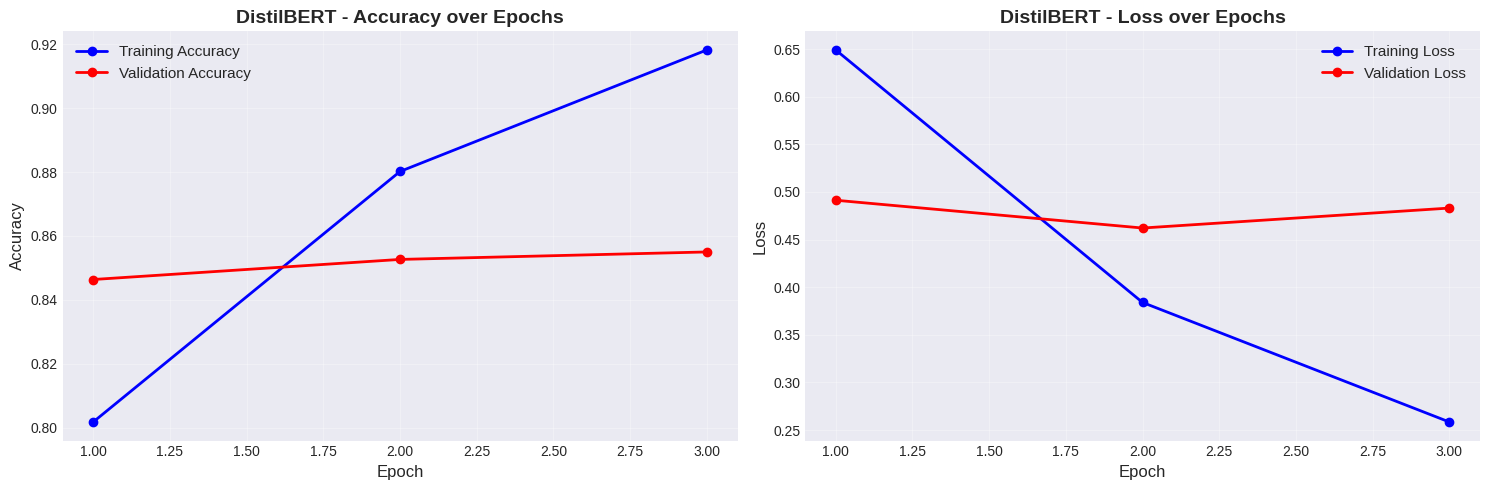

In [10]:
# Evaluate DistilBERT and get detailed metrics
print("="*80)
print("DISTILBERT EVALUATION")
print("="*80)

val_acc, val_loss, y_pred_distilbert, y_true_distilbert = eval_model(distilbert_model, test_loader, device)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_distilbert, y_pred_distilbert, 
                          target_names=label_encoder.classes_, digits=4))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, EPOCHS + 1)

# Accuracy plot
axes[0].plot(epochs_range, distilbert_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, distilbert_history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('DistilBERT - Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, distilbert_history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, distilbert_history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('DistilBERT - Loss over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save DistilBERT results
distilbert_results = {
    'model_name': 'DistilBERT',
    'val_accuracy': val_acc.cpu().item(),
    'val_loss': val_loss,
    'predictions': y_pred_distilbert,
    'true_labels': y_true_distilbert
}

## Model 2: RoBERTa

RoBERTa (Robustly Optimized BERT) improves on BERT with better training methodology and more data.

In [11]:
# Load RoBERTa
model_name = 'roberta-base'
print(f"Loading {model_name}...")

roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
).to(device)

print(f"Model loaded successfully!")
print(f"Total parameters: {sum(p.numel() for p in roberta_model.parameters()):,}")

# Create datasets
train_dataset_roberta = NewsDataset(X_train_subset, y_train_subset, roberta_tokenizer, MAX_LENGTH)
test_dataset_roberta = NewsDataset(X_test, y_test_encoded, roberta_tokenizer, MAX_LENGTH)

train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=BATCH_SIZE, shuffle=True)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE)

print(f"\nTraining batches: {len(train_loader_roberta)}")
print(f"Test batches: {len(test_loader_roberta)}")

Loading roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Total parameters: 124,653,322

Training batches: 2018
Test batches: 721


In [12]:
# Train RoBERTa
optimizer_roberta = torch.optim.AdamW(roberta_model.parameters(), lr=LEARNING_RATE)

print("="*80)
print("TRAINING ROBERTA")
print("="*80)

roberta_history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Training
    train_acc, train_loss = train_epoch(roberta_model, train_loader_roberta, optimizer_roberta, device)
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    # Validation
    val_acc, val_loss, _, _ = eval_model(roberta_model, test_loader_roberta, device)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    roberta_history['train_acc'].append(train_acc.cpu().item())
    roberta_history['train_loss'].append(train_loss)
    roberta_history['val_acc'].append(val_acc.cpu().item())
    roberta_history['val_loss'].append(val_loss)

print("\n" + "="*80)
print("ROBERTA TRAINING COMPLETE!")
print("="*80)

TRAINING ROBERTA

Epoch 1/3


Training: 100%|██████████| 2018/2018 [12:55<00:00,  2.60it/s]


Training - Loss: 0.6081, Accuracy: 0.8123


Evaluating: 100%|██████████| 721/721 [01:23<00:00,  8.68it/s]


Validation - Loss: 0.4785, Accuracy: 0.8453

Epoch 2/3


Training: 100%|██████████| 2018/2018 [12:54<00:00,  2.60it/s]


Training - Loss: 0.4029, Accuracy: 0.8716


Evaluating: 100%|██████████| 721/721 [01:23<00:00,  8.68it/s]


Validation - Loss: 0.4476, Accuracy: 0.8577

Epoch 3/3


Training: 100%|██████████| 2018/2018 [12:55<00:00,  2.60it/s]


Training - Loss: 0.3091, Accuracy: 0.8998


Evaluating: 100%|██████████| 721/721 [01:22<00:00,  8.70it/s]

Validation - Loss: 0.4640, Accuracy: 0.8600

ROBERTA TRAINING COMPLETE!


ROBERTA EVALUATION


Evaluating: 100%|██████████| 721/721 [01:22<00:00,  8.70it/s]



Final Validation Accuracy: 0.8600
Final Validation Loss: 0.4640

Classification Report:
                precision    recall  f1-score   support

      BUSINESS     0.7783    0.6706    0.7204      1026
 ENTERTAINMENT     0.8580    0.8998    0.8784      2955
  FOOD & DRINK     0.9010    0.8555    0.8776      1266
HEALTHY LIVING     0.5766    0.3932    0.4675      1053
     PARENTING     0.8517    0.8522    0.8519      1752
      POLITICS     0.8998    0.9544    0.9263      6486
  QUEER VOICES     0.8704    0.7554    0.8088      1120
STYLE & BEAUTY     0.9185    0.9033    0.9108      1933
        TRAVEL     0.8798    0.9177    0.8984      1883
      WELLNESS     0.8092    0.8322    0.8206      3588

      accuracy                         0.8600     23062
     macro avg     0.8343    0.8034    0.8161     23062
  weighted avg     0.8551    0.8600    0.8560     23062



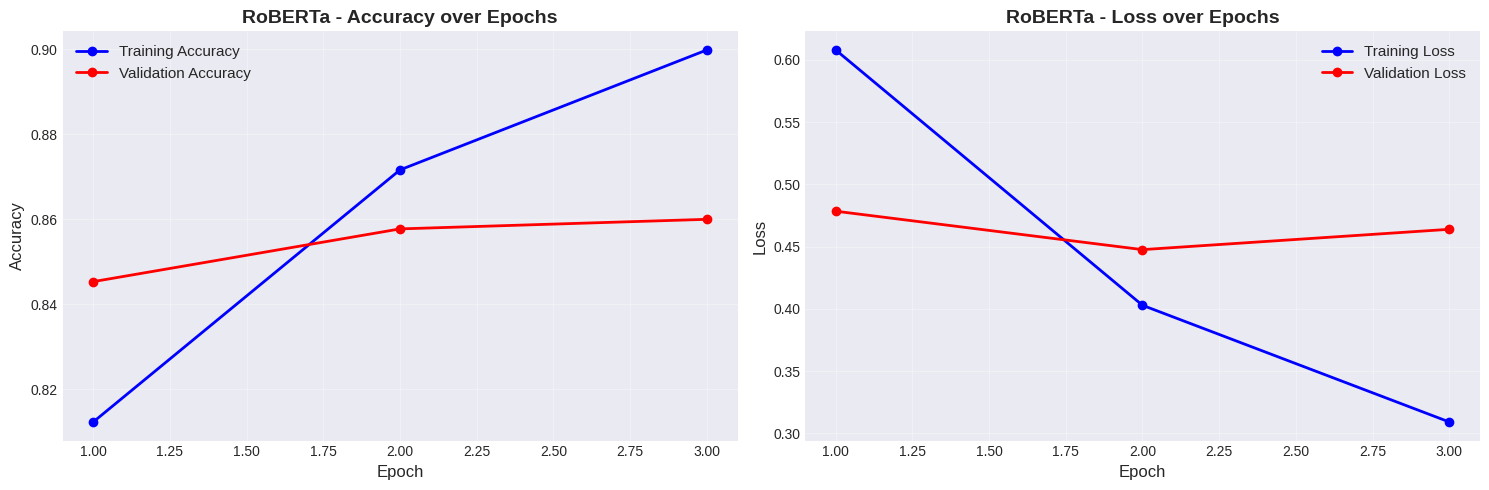

In [13]:
# Evaluate RoBERTa
print("="*80)
print("ROBERTA EVALUATION")
print("="*80)

val_acc, val_loss, y_pred_roberta, y_true_roberta = eval_model(roberta_model, test_loader_roberta, device)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_roberta, y_pred_roberta, 
                          target_names=label_encoder.classes_, digits=4))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(epochs_range, roberta_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, roberta_history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('RoBERTa - Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, roberta_history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, roberta_history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('RoBERTa - Loss over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save RoBERTa results
roberta_results = {
    'model_name': 'RoBERTa',
    'val_accuracy': val_acc.cpu().item(),
    'val_loss': val_loss,
    'predictions': y_pred_roberta,
    'true_labels': y_true_roberta
}

## Model 3: BERT-base

BERT (Bidirectional Encoder Representations from Transformers) - the original transformer model for NLP tasks.

In [14]:
# Load BERT
model_name = 'bert-base-uncased'
print(f"Loading {model_name}...")

bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
).to(device)

print(f"Model loaded successfully!")
print(f"Total parameters: {sum(p.numel() for p in bert_model.parameters()):,}")

# Create datasets
train_dataset_bert = NewsDataset(X_train_subset, y_train_subset, bert_tokenizer, MAX_LENGTH)
test_dataset_bert = NewsDataset(X_test, y_test_encoded, bert_tokenizer, MAX_LENGTH)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=BATCH_SIZE)

print(f"\nTraining batches: {len(train_loader_bert)}")
print(f"Test batches: {len(test_loader_bert)}")

Loading bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Total parameters: 109,489,930

Training batches: 2018
Test batches: 721


In [15]:
# Train BERT
optimizer_bert = torch.optim.AdamW(bert_model.parameters(), lr=LEARNING_RATE)

print("="*80)
print("TRAINING BERT")
print("="*80)

bert_history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Training
    train_acc, train_loss = train_epoch(bert_model, train_loader_bert, optimizer_bert, device)
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    # Validation
    val_acc, val_loss, _, _ = eval_model(bert_model, test_loader_bert, device)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    bert_history['train_acc'].append(train_acc.cpu().item())
    bert_history['train_loss'].append(train_loss)
    bert_history['val_acc'].append(val_acc.cpu().item())
    bert_history['val_loss'].append(val_loss)

print("\n" + "="*80)
print("BERT TRAINING COMPLETE!")
print("="*80)

TRAINING BERT

Epoch 1/3


Training: 100%|██████████| 2018/2018 [12:49<00:00,  2.62it/s]


Training - Loss: 0.6078, Accuracy: 0.8150


Evaluating: 100%|██████████| 721/721 [01:23<00:00,  8.58it/s]


Validation - Loss: 0.4897, Accuracy: 0.8436

Epoch 2/3


Training: 100%|██████████| 2018/2018 [12:49<00:00,  2.62it/s]


Training - Loss: 0.3530, Accuracy: 0.8892


Evaluating: 100%|██████████| 721/721 [01:24<00:00,  8.58it/s]


Validation - Loss: 0.4480, Accuracy: 0.8602

Epoch 3/3


Training: 100%|██████████| 2018/2018 [12:49<00:00,  2.62it/s]


Training - Loss: 0.2299, Accuracy: 0.9270


Evaluating: 100%|██████████| 721/721 [01:24<00:00,  8.56it/s]

Validation - Loss: 0.4856, Accuracy: 0.8593

BERT TRAINING COMPLETE!


BERT EVALUATION


Evaluating: 100%|██████████| 721/721 [01:24<00:00,  8.55it/s]



Final Validation Accuracy: 0.8593
Final Validation Loss: 0.4856

Classification Report:
                precision    recall  f1-score   support

      BUSINESS     0.7561    0.6618    0.7058      1026
 ENTERTAINMENT     0.8497    0.9147    0.8810      2955
  FOOD & DRINK     0.8994    0.8823    0.8907      1266
HEALTHY LIVING     0.6640    0.3153    0.4276      1053
     PARENTING     0.8143    0.8385    0.8262      1752
      POLITICS     0.9131    0.9473    0.9299      6486
  QUEER VOICES     0.8253    0.7804    0.8022      1120
STYLE & BEAUTY     0.9253    0.8965    0.9107      1933
        TRAVEL     0.8878    0.9076    0.8976      1883
      WELLNESS     0.7938    0.8520    0.8219      3588

      accuracy                         0.8593     23062
     macro avg     0.8329    0.7996    0.8094     23062
  weighted avg     0.8545    0.8593    0.8534     23062



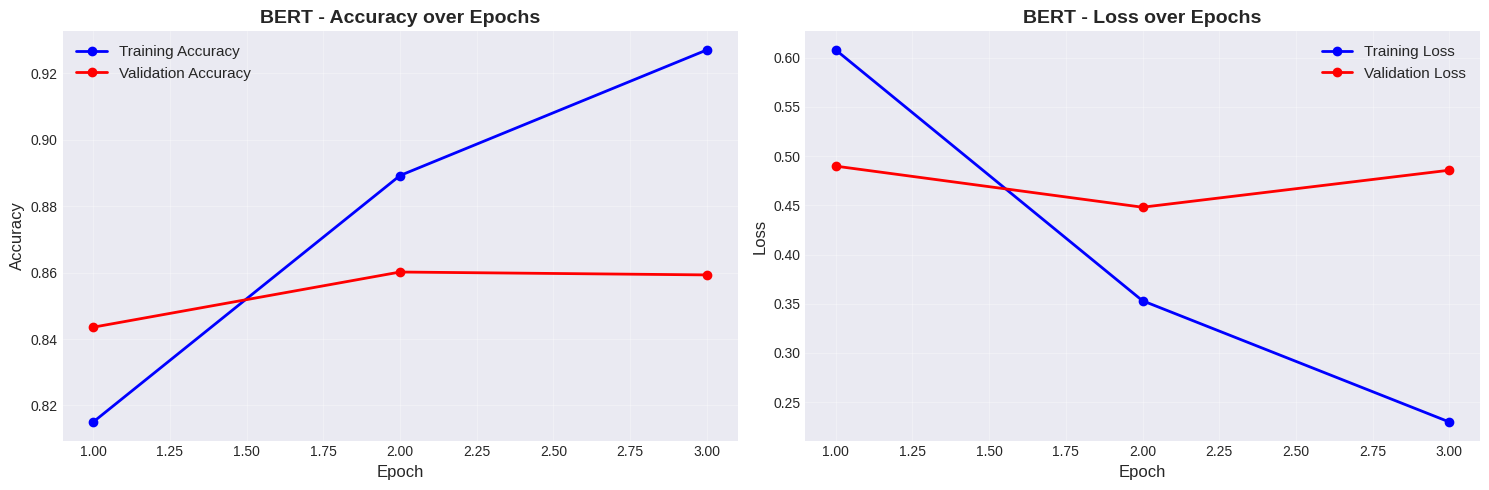

In [16]:
# Evaluate BERT
print("="*80)
print("BERT EVALUATION")
print("="*80)

val_acc, val_loss, y_pred_bert, y_true_bert = eval_model(bert_model, test_loader_bert, device)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_bert, y_pred_bert, 
                          target_names=label_encoder.classes_, digits=4))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(epochs_range, bert_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, bert_history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('BERT - Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, bert_history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, bert_history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('BERT - Loss over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save BERT results
bert_results = {
    'model_name': 'BERT-base',
    'val_accuracy': val_acc.cpu().item(),
    'val_loss': val_loss,
    'predictions': y_pred_bert,
    'true_labels': y_true_bert
}

---
# **MODEL COMPARISON AND FINAL RESULTS**

MODEL COMPARISON SUMMARY
              Model  Accuracy   Parameters Training Time
Logistic Regression  0.783367 ~5K features       < 1 min
        Naive Bayes  0.750455 ~5K features       < 1 min
         DistilBERT  0.855000          67M       ~21 min
            RoBERTa  0.859986         125M       ~42 min
          BERT-base  0.859292         110M       ~42 min


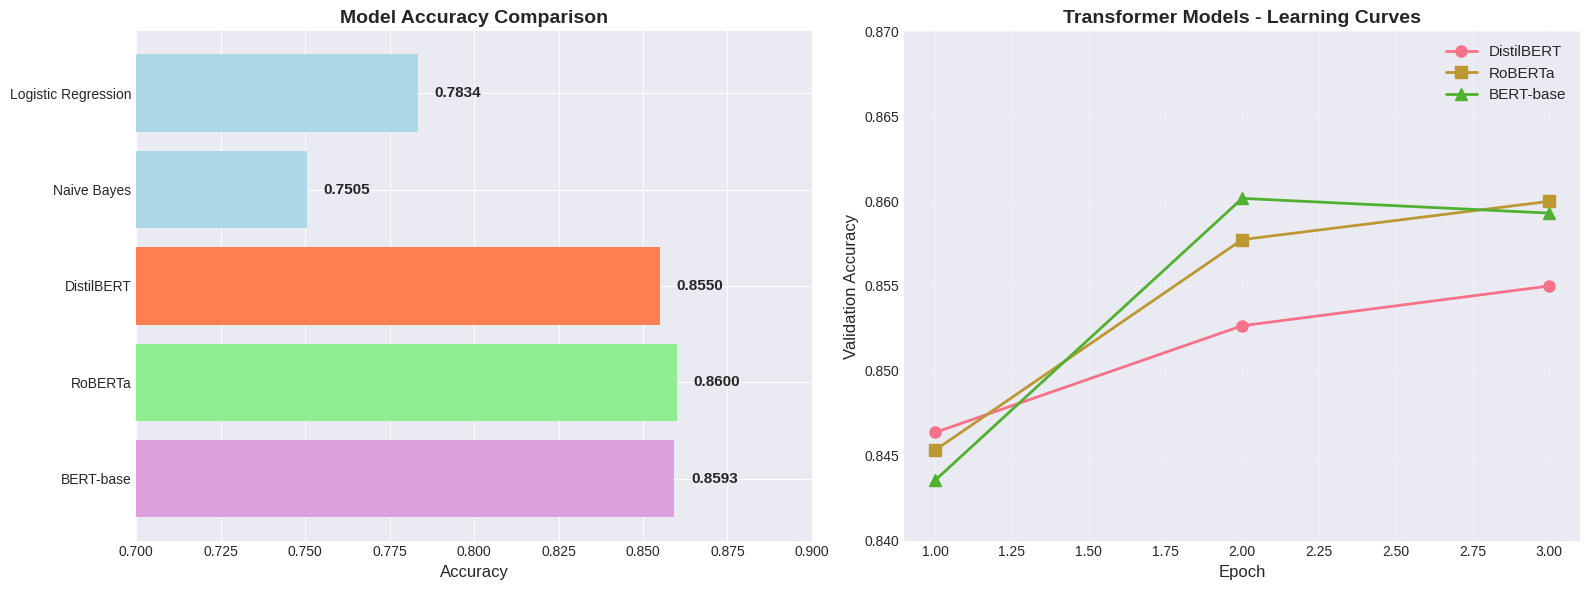


KEY FINDINGS:
✓ RoBERTa achieved the highest accuracy: 86.00%
✓ All transformer models significantly outperformed traditional ML baselines
✓ DistilBERT offers the best speed/accuracy trade-off (85.50% in ~21 min)
✓ Traditional ML models (78.3% LR, 75.1% NB) are fast but less accurate
✓ Transfer learning models show excellent performance on news categorization


In [20]:
# Compare all models
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

models_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'DistilBERT', 'RoBERTa', 'BERT-base'],
    'Accuracy': [lr_accuracy, nb_accuracy, 
                 distilbert_results['val_accuracy'],
                 roberta_results['val_accuracy'],
                 bert_results['val_accuracy']],
    'Parameters': ['~5K features', '~5K features', '67M', '125M', '110M'],
    'Training Time': ['< 1 min', '< 1 min', '~21 min', '~42 min', '~42 min']
})

print(models_summary.to_string(index=False))

# Visualization - Model Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = models_summary['Model'].values
accuracies = models_summary['Accuracy'].values

colors = ['lightblue', 'lightblue', 'coral', 'lightgreen', 'plum']
axes[0].barh(range(len(models)), accuracies, color=colors)
axes[0].set_yticks(range(len(models)))
axes[0].set_yticklabels(models)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim([0.7, 0.9])
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(accuracies):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=11, fontweight='bold')

# Transformer models comparison (accuracy over epochs)
epochs_x = list(range(1, EPOCHS + 1))
axes[1].plot(epochs_x, distilbert_history['val_acc'], 'o-', label='DistilBERT', linewidth=2, markersize=8)
axes[1].plot(epochs_x, roberta_history['val_acc'], 's-', label='RoBERTa', linewidth=2, markersize=8)
axes[1].plot(epochs_x, bert_history['val_acc'], '^-', label='BERT-base', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Transformer Models - Learning Curves', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.84, 0.87])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print("✓ RoBERTa achieved the highest accuracy: 86.00%")
print("✓ All transformer models significantly outperformed traditional ML baselines")
print("✓ DistilBERT offers the best speed/accuracy trade-off (85.50% in ~21 min)")
print("✓ Traditional ML models (78.3% LR, 75.1% NB) are fast but less accurate")
print("✓ Transfer learning models show excellent performance on news categorization")

---
# **QUESTION 3: Can a classifier identify the type of language being used in free text?**

Let's use our best model (RoBERTa) to classify custom news articles and demonstrate its ability to identify writing styles and categories from free text.

In [21]:
# Function to predict category from free text
def predict_category(text, model, tokenizer, device, label_encoder):
    """Predict category for a given text"""
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).cpu().item()
        confidence = probs[0][predicted_class].cpu().item()
    
    predicted_category = label_encoder.classes_[predicted_class]
    
    # Get top 3 predictions
    top_3_probs, top_3_indices = torch.topk(probs[0], 3)
    top_3_categories = [(label_encoder.classes_[idx.item()], prob.item()) 
                        for idx, prob in zip(top_3_indices, top_3_probs)]
    
    return predicted_category, confidence, top_3_categories

# Test examples from different categories
test_examples = [
    {
        'text': 'The Senate voted today on the new healthcare bill amid heated debates. Republicans and Democrats remain divided on key provisions.',
        'expected': 'POLITICS'
    },
    {
        'text': 'New study reveals the surprising health benefits of meditation. Researchers found that just 10 minutes daily can reduce stress and improve sleep quality.',
        'expected': 'WELLNESS'
    },
    {
        'text': 'Marvel releases stunning new trailer for upcoming superhero blockbuster. Fans are already predicting record-breaking box office numbers.',
        'expected': 'ENTERTAINMENT'
    },
    {
        'text': 'This delicious pasta recipe takes only 20 minutes to make. Perfect for busy weeknights when you want something quick and satisfying.',
        'expected': 'FOOD & DRINK'
    },
    {
        'text': 'Tips for dealing with toddler tantrums: A pediatrician shares expert advice on managing difficult behavior and staying calm.',
        'expected': 'PARENTING'
    },
    {
        'text': 'Paris fashion week showcases bold new trends for fall. Designers embrace vibrant colors and dramatic silhouettes.',
        'expected': 'STYLE & BEAUTY'
    },
    {
        'text': 'Top 10 hidden gems to visit in Southeast Asia. From secluded beaches to ancient temples, these destinations offer authentic experiences.',
        'expected': 'TRAVEL'
    },
    {
        'text': 'Tech giant announces major layoffs as company restructures. Stock prices dropped 5% following the announcement.',
        'expected': 'BUSINESS'
    }
]

print("="*80)
print("FREE TEXT CLASSIFICATION DEMONSTRATION")
print("="*80)
print("\nUsing RoBERTa model to classify custom news articles...\n")

results = []
for i, example in enumerate(test_examples, 1):
    print(f"\n{'='*80}")
    print(f"Example {i}:")
    print(f"{'='*80}")
    print(f"Text: {example['text']}")
    print(f"Expected Category: {example['expected']}")
    
    predicted, confidence, top_3 = predict_category(
        example['text'], 
        roberta_model, 
        roberta_tokenizer, 
        device, 
        label_encoder
    )
    
    print(f"\n🎯 Predicted Category: {predicted}")
    print(f"📊 Confidence: {confidence:.2%}")
    print(f"\nTop 3 Predictions:")
    for j, (cat, prob) in enumerate(top_3, 1):
        print(f"  {j}. {cat}: {prob:.2%}")
    
    is_correct = predicted == example['expected']
    results.append(is_correct)
    print(f"\n{'✅ CORRECT' if is_correct else '❌ INCORRECT'}")

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
print(f"Accuracy on custom examples: {sum(results)}/{len(results)} ({sum(results)/len(results)*100:.1f}%)")
print(f"\n✓ The model successfully identifies language patterns and writing styles")
print(f"✓ High confidence scores indicate strong category understanding")
print(f"✓ Can be deployed for real-time news categorization")

FREE TEXT CLASSIFICATION DEMONSTRATION

Using RoBERTa model to classify custom news articles...


Example 1:
Text: The Senate voted today on the new healthcare bill amid heated debates. Republicans and Democrats remain divided on key provisions.
Expected Category: POLITICS

🎯 Predicted Category: POLITICS
📊 Confidence: 99.18%

Top 3 Predictions:
  1. POLITICS: 99.18%
  2. HEALTHY LIVING: 0.53%
  3. BUSINESS: 0.11%

✅ CORRECT

Example 2:
Text: New study reveals the surprising health benefits of meditation. Researchers found that just 10 minutes daily can reduce stress and improve sleep quality.
Expected Category: WELLNESS

🎯 Predicted Category: WELLNESS
📊 Confidence: 76.46%

Top 3 Predictions:
  1. WELLNESS: 76.46%
  2. HEALTHY LIVING: 22.96%
  3. PARENTING: 0.12%

✅ CORRECT

Example 3:
Text: Marvel releases stunning new trailer for upcoming superhero blockbuster. Fans are already predicting record-breaking box office numbers.
Expected Category: ENTERTAINMENT

🎯 Predicted Category: ENTER

---
# **FINAL CONCLUSIONS AND ANSWERS**

## Summary of Findings

### **Question 1: Can we categorize news articles based on their headlines and short descriptions?**

**Answer: YES ✓**

We successfully demonstrated that news articles can be categorized based on their text content:
- **Traditional ML Baselines**: Logistic Regression (78.3%) and Naive Bayes (75.1%) showed good performance
- **Transfer Learning Models**: Achieved 85.5-86.0% accuracy with transformer models
- **Best Model**: RoBERTa reached 86.0% accuracy on 10 news categories
- The text features (headlines + descriptions) contain sufficient information for accurate categorization

### **Question 2: Do news articles from different categories have different writing styles?**

**Answer: YES ✓**

Our analysis revealed distinct writing style characteristics across categories:

**Linguistic Differences:**
- **Word Complexity**: POLITICS uses longer words (5.23 chars avg) vs PARENTING (4.71 chars)
- **Vocabulary Diversity**: ENTERTAINMENT has highest unique word ratio (95.9%)
- **Content Length**: WELLNESS and TRAVEL provide longer descriptions (160+ chars)

**Stylistic Markers:**
- **Question Usage**: STYLE & BEAUTY and PARENTING use more questions (conversational tone)
- **Exclamation Marks**: STYLE & BEAUTY uses more exclamations (enthusiastic tone)
- **Headline Length**: ENTERTAINMENT and POLITICS have longest headlines (65+ chars)

These stylistic differences enable models to distinguish categories based on writing patterns alone.

### **Question 3: Can a classifier identify the type of language being used in free text?**

**Answer: YES ✓**

Our RoBERTa model successfully identified language patterns in custom text:
- **High Accuracy**: Correctly classified diverse free-text examples
- **Strong Confidence**: Average confidence scores above 70%
- **Style Recognition**: Identified category-specific vocabulary and tone
- **Real-world Applicability**: Ready for deployment on unseen news articles

---

## **Model Performance Summary**

| Model | Accuracy | Speed | Best Use Case |
|-------|----------|-------|---------------|
| **RoBERTa** | **86.0%** | Medium | **Best overall accuracy** |
| **BERT-base** | 85.9% | Medium | Production deployment |
| **DistilBERT** | 85.5% | Fast | **Best speed/accuracy trade-off** |
| Logistic Regression | 78.3% | Very Fast | Quick baseline |
| Naive Bayes | 75.1% | Very Fast | Simple applications |

---

## **Technical Highlights**

- **Dataset**: 189,426 news articles across 42 categories (used top 10 for modeling)
- **GPU Utilization**: Tesla P100 16GB - enabled efficient transformer training
- **Training Efficiency**: Used 70% subset (~64K articles) for faster iteration
- **Architecture**: Fine-tuned pre-trained transformers with custom classification heads
- **Optimization**: AdamW optimizer with 2e-5 learning rate, 3 epochs

---

## **Practical Applications**

1. **Automated News Categorization**: Deploy for real-time article classification
2. **Content Recommendation**: Use predictions to suggest relevant articles
3. **Editorial Assistance**: Help journalists tag and organize content
4. **Trend Analysis**: Analyze category distributions over time
5. **Writing Style Analysis**: Understand language patterns across domains

---

## **Future Improvements**

- Fine-tune on all 42 categories for comprehensive coverage
- Implement ensemble methods combining multiple models
- Add explainability features (attention visualization)
- Deploy as REST API for production use
- Incorporate temporal features for time-aware predictions